# **LOCAL SEARCH AND CONSTRAINT SATISFACTION PROBLEMS**



---



For this implementation, we're going to use the known problem "Travelling Salesman Problem (TSP)".

This problem was adapted into a more rovust one, to be possible to use it for each algorithm. With the goal to compare the results obtained for each method for a full comparison.

In [ ]:
import math, time, random, itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

The explanation for each function and def will be commented on the code.

Summary:
- Construction of eucledian distance matrix
- Length of the route (tour)
- Generation of tours (random or deterministic)
- Generation of neighbors
- Visualization of the rout with ```matplotlib```



First, the construction of the problem with 7 cities (nodes).

**TRAVELLING SALESMAN PROBLEM**

Deterministic initial tour: [0, 1, 2, 3, 4, 5, 6]
Deterministic initial length: 22.380207348497493


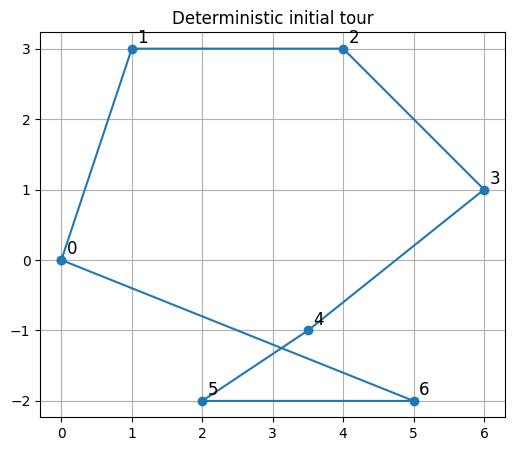

In [ ]:
# ------------------------------------------
# Travelling Salesman Map (7 cities)
# ------------------------------------------


# Array with 7x2 with (x,y) positions of each city
# and N_CITIES will save the numbers of the cities (7).
# Also, these distances can be changed to test even more the algorithms!

CITIES_COORDS = np.array([
    [0.0, 0.0],   # City 0
    [1.0, 3.0],   # City 1
    [4.0, 3.0],   # City 2
    [6.0, 1.0],   # City 3
    [3.5, -1.0],  # City 4
    [2.0, -2.0],  # City 5
    [5.0, -2.0],  # City 6
])

N_CITIES = CITIES_COORDS.shape[0]


# For the calculation of the euclidean distance for each city
# there's the use of math.hypot(dx, dy), for the complete distance
# between 2 points (robust for this kind of problem). Have in mind that
# this amount of cities would be perfect to test the algorithms in an
# appropriate scale.

# Then, there's the construction of a symmetric 'D' with the distance between
# each pair of cities. And the matrix obtained will be used to evaluate each
# tour.

def euclidean_distance(a, b):
    return math.hypot(a[0] - b[0], a[1] - b[1])


def build_distance_matrix(coords):
    n = coords.shape[0]
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            d = euclidean_distance(coords[i], coords[j])
            D[i, j] = d
            D[j, i] = d
    return D

DIST_MATRIX = build_distance_matrix(CITIES_COORDS)


# 'tour' is a permutation of cities index. The function will sum the distance
# between cities in a consecutive way, and also will include the round from the last city
# to the first (initial node) as a closed circuit.
# Finally, will give us the TOTAL length as a 'float'.

def tour_length(tour, dist_matrix=DIST_MATRIX):
    tour = list(tour)
    total = 0.0
    for i in range(len(tour)):
        a = tour[i]
        b = tour[(i + 1) % len(tour)]
        total += dist_matrix[a, b]
    return total


# Generate a random permutation (tour) of n cities. 'random_tour' gives a
# random permutation from 0 ... n-1. Useful for experiments with random starts.

def random_tour(n=N_CITIES, seed=None):
    if seed is not None:
        random.seed(seed)
    tour = list(range(n))
    random.shuffle(tour)
    return tour


# The neighbor operatos (swap and 2-opt) will generated a nearby 'tour' (a permutation)
# an initial "solution" derived from the current tour.

def swap_two_cities(tour, i=None, j=None, seed=None):
    if seed is not None:
        random.seed(seed)
    t = tour.copy()
    n = len(t)
    if i is None or j is None:
        i, j = random.sample(range(n), 2)
    t[i], t[j] = t[j], t[i]
    return t


def two_opt(tour, i=None, j=None, seed=None):
    if seed is not None:
        random.seed(seed)
    t = tour.copy()
    n = len(t)
    if i is None or j is None:
        i, j = sorted(random.sample(range(n), 2))
    if i >= j:
        return t
    t[i:j+1] = reversed(t[i:j+1])
    return t


# ---------- Visualization ----------

def plot_tour(tour, coords=CITIES_COORDS, show_labels=True, title=None):
    tour = list(tour)
    xs = coords[:, 0]
    ys = coords[:, 1]

    tour_coords = np.vstack([coords[tour], coords[tour[0]]])

    plt.figure(figsize=(6, 5))
    plt.plot(tour_coords[:, 0], tour_coords[:, 1], marker='o')
    if show_labels:
        for idx, (x, y) in enumerate(coords):
            plt.text(x + 0.08, y + 0.08, str(idx), fontsize=12)

    if title is None:
        title = f"Tour length = {tour_length(tour):.3f}"
    plt.title(title)
    plt.axis('equal')
    plt.grid(True)
    plt.show()

# Global results store to be filled by each method
RESULTS = {}

# ---------- Example usage ----------
if __name__ == '__main__':
    # Use a deterministic initial tour (cities in index order) to avoid random graph/tour generation
    deterministic_initial = list(range(N_CITIES))
    print('Deterministic initial tour:', deterministic_initial)
    print('Deterministic initial length:', tour_length(deterministic_initial))
    plot_tour(deterministic_initial, title='Deterministic initial tour')


# **Algorithms to Implement:**
1. Random walk (theory done)
2. Hill climbing (theory done)
3. Randomized hill climbing (theory done)
4. Gradient ascent (steepest ascent)
5. Gradient descent
6. Simulated annealing
7. Eight queens problem
8. Map coloring
9. Magic triangle

To prove all these algorithms, we will use a graph coloring problem, where we will fin the solution by implementing each method and do a comparison between results. To test them and see which are more optimum interms of cost/time.



---



# LOCAL SEARCH

**1. Random walk**

This algorithm will explore the solution space by moving in a random way (the name) from one solution to another without considering wheteher the new solution is better or worse. At each step, it will generate a new random solution, regardless of quality.

The structure of this algorithm is pretty simple compared to the others:

1. It will start with an initial solution
2. For a given number of iterations
3. Return the last or best solution found

Random Walk -> length: 18.586960845293127 time: 0.0072116851806640625


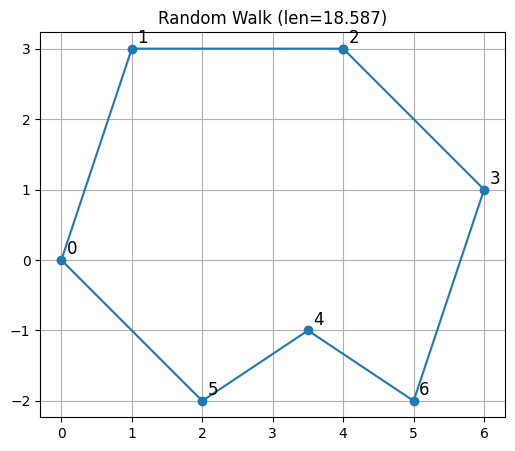

In [ ]:
start = time.time()

def random_walk(initial_tour, dist_matrix=DIST_MATRIX, iters=2000, neighbor_sampler='swap', seed=None):

  if seed is not None:
    random.seed(seed)
  current = initial_tour.copy()
  best = current.copy()
  best_len = tour_length(best, dist_matrix)
  history = [best_len]

  for k in range(iters):
    candidate = swap_two_cities(current) if neighbor_sampler=='swap' else two_opt(current)
    cand_len = tour_length(candidate, dist_matrix)

    if cand_len < best_len:
      best = candidate.copy()
      best_len = cand_len
    current = candidate
    history.append(best_len)
  return best, best_len, history


best, length, history = random_walk(deterministic_initial, iters=1000, seed=1)
end = time.time()
RESULTS['random_walk'] = {'tour':best, 'length':length, 'time':end-start, 'history':history}
print('Random Walk -> length:', length, 'time:', end-start)
plot_tour(best, title=f'Random Walk (len={length:.3f})')

**2. Hill climbing**

Using multiple iterations, will improve a single solution by exploring its neighbors and moving to the one that offers the best improvement, stoping when no better neighbor exists. This method will "climb" landscape of possible solutions, always moving toward a higher-value (or lower-cost) solution.

its structure is like this:
1. Start with an initial solution
2. Repeat this cycle: Generation of all neighbors (of S), select the best neighbor (S'), and if S' is better than S, move to S', else STOP.
3. Retunr the current solution as the local optimum.

Hill Climbing (first) -> length: 18.586960845293127 time: 0.0005857944488525391


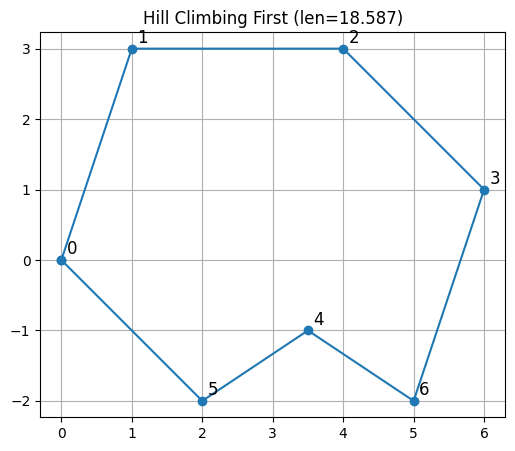

In [ ]:
start = time.time()

def hill_climbing_first(initial_tour, dist_matrix=DIST_MATRIX, max_iters=1000):

  current = initial_tour.copy()
  current_len = tour_length(current, dist_matrix)
  history = [current_len]
  n = len(current)
  it = 0

  while it < max_iters:
    improved = False
    indices = [(i, j) for i in range(n) for j in range(i+1, n)]
    random.shuffle(indices)

    for (i, j) in indices:
      t = current.copy()
      t[i], t[j] = t[j], t[i]
      l = tour_length(t, dist_matrix)

      if l < current_len:
        current = t
        current_len = l
        history.append(current_len)
        improved = True
        break

    if not improved:
      break
    it += 1

  return current, current_len, history


best, length, history = hill_climbing_first(deterministic_initial)
end = time.time()
RESULTS['hill_climbing_first'] = {'tour':best, 'length':length, 'time':end-start, 'history':history}
print('Hill Climbing (first) -> length:', length, 'time:', end-start)
plot_tour(best, title=f'Hill Climbing First (len={length:.3f})')

**3. Randomized hill climbing**

This method introduces randomness into the known "Hill Climbing" algorithm. Instead of always choosing the best neighbor, it randomly selects among better or equally good neighbors, which helps the avoidance of selecting local optima.

For its structure:
1. Start with an initial solution S
2. It will repeat: Generation of a random neighbot S', if S' is better than S, move to S'
3. Continue until the stopping condition is met
4. Return the best solution found

Randomized Hill Climbing -> length: 18.586960845293127 time: 0.0019483566284179688


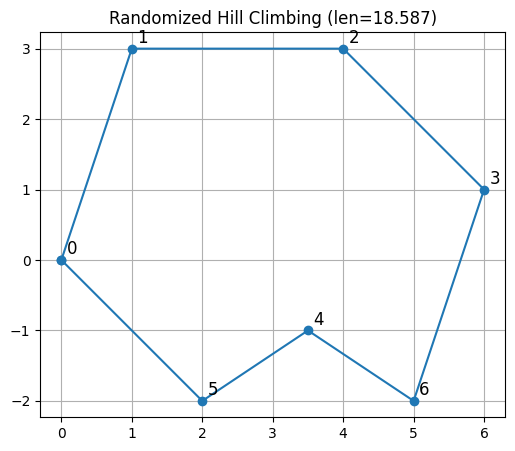

In [ ]:
start = time.time()

def randomized_hill_climbing(initial_tour, dist_matrix=DIST_MATRIX, max_iters=1000, p_random_accept=0.02, neighborhood='swap', seed=None):

  if seed is not None:
    random.seed(seed)
  current = initial_tour.copy()
  current_len = tour_length(current, dist_matrix)
  history = [current_len]
  n = len(current)

  for it in range(max_iters):
    improved = False
    indices = [(i, j) for i in range(n) for j in range(i+1, n)]
    random.shuffle(indices)

    for (i, j) in indices:
      t = current.copy()

      if neighborhood == 'swap':
        t[i], t[j] = t[j], t[i]

      else:
        t[i:j+1] = list(reversed(t[i:j+1]))
      l = tour_length(t, dist_matrix)

      if l < current_len:
        current = t
        current_len = l
        history.append(current_len)
        improved = True
        break
      else:
        if random.random() < p_random_accept:
          current = t
          current_len = l
          history.append(current_len)
          improved = True
          break

    if not improved:
      break
  return current, current_len, history


best, length, history = randomized_hill_climbing(deterministic_initial, seed=2)
end = time.time()
RESULTS['randomized_hill_climbing'] = {'tour':best, 'length':length, 'time':end-start, 'history':history}
print('Randomized Hill Climbing -> length:', length, 'time:', end-start)
plot_tour(best, title=f'Randomized Hill Climbing (len={length:.3f})')

**4. Gradient Ascent**

Its main use is to maximize a function by iteratively moving in the direction of the steepest increase (a gradient). At each iteration, it will evaluate all possible moves and chooses the one that increases the objective function the most.

For the structure:
1. Initial solution S
2. Repeat until convergence: Evaluate all possible neighbors, choose the N with maximum improvement and update the current S to this N
3. Return the best solution found

Steepest Ascent (2-opt) -> length: 18.586960845293127 time: 0.0007317066192626953


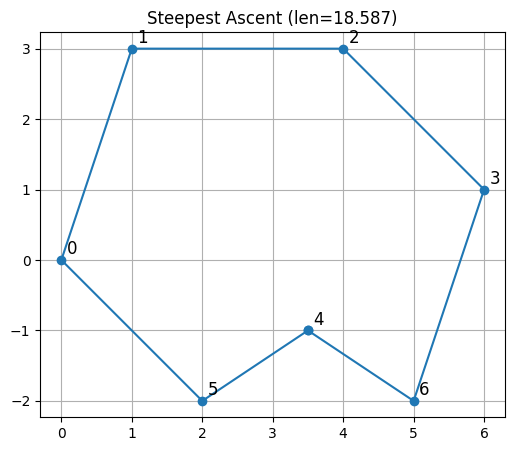

In [ ]:
start = time.time()

def steepest_ascent_hill_climbing(initial_tour, dist_matrix=DIST_MATRIX, max_iters=1000, neighborhood='swap'):

  current = initial_tour.copy()
  current_len = tour_length(current, dist_matrix)
  history = [current_len]

  for it in range(max_iters):
    best_local = None
    best_local_len = current_len
    n = len(current)

    if neighborhood == 'swap':
      for i in range(n):
        for j in range(i+1, n):
            t = current.copy()
            t[i], t[j] = t[j], t[i]
            l = tour_length(t, dist_matrix)
            if l < best_local_len:
              best_local_len = l
              best_local = t
    else:
      for i in range(n):
        for j in range(i+1, n):
            t = current.copy()
            t[i:j+1] = list(reversed(t[i:j+1]))
            l = tour_length(t, dist_matrix)
            if l < best_local_len:
              best_local_len = l
              best_local = t

    if best_local is None:
      break

    current = best_local
    current_len = best_local_len
    history.append(current_len)

  return current, current_len, history

best, length, history = steepest_ascent_hill_climbing(deterministic_initial, neighborhood='2-opt')
end = time.time()
RESULTS['steepest_ascent'] = {'tour':best, 'length':length, 'time':end-start, 'history':history}
print('Steepest Ascent (2-opt) -> length:', length, 'time:', end-start)
plot_tour(best, title=f'Steepest Ascent (len={length:.3f})')

**5. Gradient Descent**

Opposite of Gradient Ascent (GA). It is used to minimize an objective function by moving in the direction of the steepest decrease, It moves toward shorter distances step by step. At each step, it will select the neighboring solution that most decreases the total path length.

The structure:
1. Initial solution S
2. Repeat: Generation of all neighbors, choose the neighbor S' that most decreases the cost, if S' improves the solution, move to S' or will stop
3. Retunr the monimum-cost solution

Gradient Descent (discrete) -> length: 18.586960845293127 time: 0.0004458427429199219


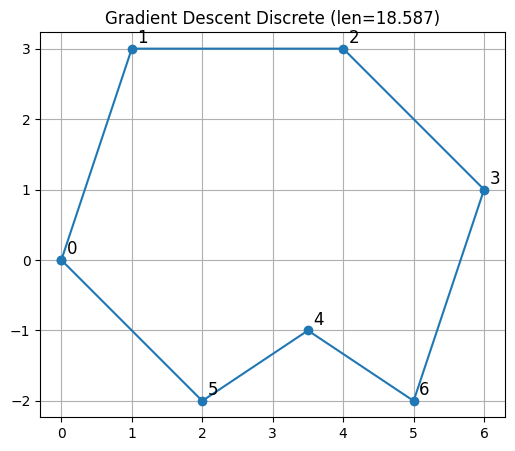

In [ ]:
start = time.time()

def gradient_descent_discrete(initial_tour, dist_matrix=DIST_MATRIX, max_iters=1000):
# discrete steepest descent over swap neighbors
  return steepest_ascent_hill_climbing(initial_tour, dist_matrix, max_iters=max_iters, neighborhood='swap')


best, length, history = gradient_descent_discrete(deterministic_initial)
end = time.time()
RESULTS['gradient_descent_discrete'] = {'tour':best, 'length':length, 'time':end-start, 'history':history}
print('Gradient Descent (discrete) -> length:', length, 'time:', end-start)
plot_tour(best, title=f'Gradient Descent Discrete (len={length:.3f})')

**6. Simulated Annealing**

Inspired by the annealing process in metallurgy. It explores the solution by sometimes accepting worse solutions to escape local minima, with this probability decreasing over time. At each step, a random neighbor is generated. If it's better, it's accepted. If it's worse, it may still be accepted depending on probability that depends on temperature T.

The structure is:
1. Initialize solution S and temperature T.
2. Repeat until T is very small:
* Generate a random neighbor S'.
* Compute the cost difference Δ.
* If Δ < 0, accept S'.
* Else accept S' with probability exp(-Δ / T).
* Decrease the temperature.
3. Return the best solution found.

Simulated Annealing -> length: 18.586960845293127 time: 0.018401384353637695


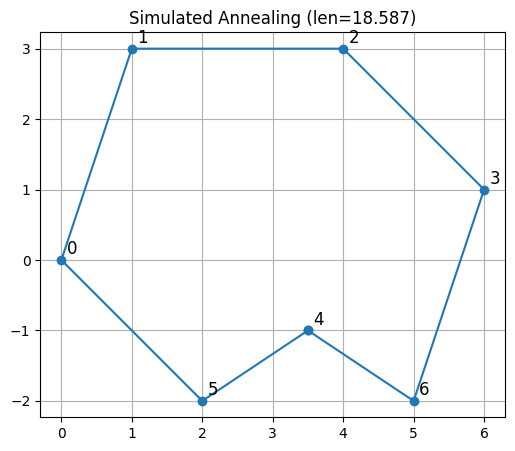

In [ ]:
start = time.time()

def simulated_annealing(initial_tour, dist_matrix=DIST_MATRIX, iters=3000, T0=1.0, alpha=0.998, neighbor='2-opt', seed=None):

  if seed is not None:
    random.seed(seed)
  current = initial_tour.copy()
  current_len = tour_length(current, dist_matrix)
  best = current.copy()
  best_len = current_len
  history = [current_len]
  T = T0

  for k in range(iters):
    candidate = swap_two_cities(current) if neighbor=='swap' else two_opt(current)
    cand_len = tour_length(candidate, dist_matrix)
    delta = cand_len - current_len

    if delta < 0 or random.random() < math.exp(-delta / max(T, 1e-12)):
      current = candidate
      current_len = cand_len

      if current_len < best_len:
        best = current.copy()
        best_len = current_len
    history.append(best_len)
    T *= alpha

  return best, best_len, history

best, length, history = simulated_annealing(deterministic_initial, iters=2000, neighbor='2-opt', seed=3)
end = time.time()
RESULTS['simulated_annealing'] = {'tour':best, 'length':length, 'time':end-start, 'history':history}
print('Simulated Annealing -> length:', length, 'time:', end-start)
plot_tour(best, title=f'Simulated Annealing (len={length:.3f})')



---



**COMPARISON BETWEEN RESULTS (ALGORITHMS)**

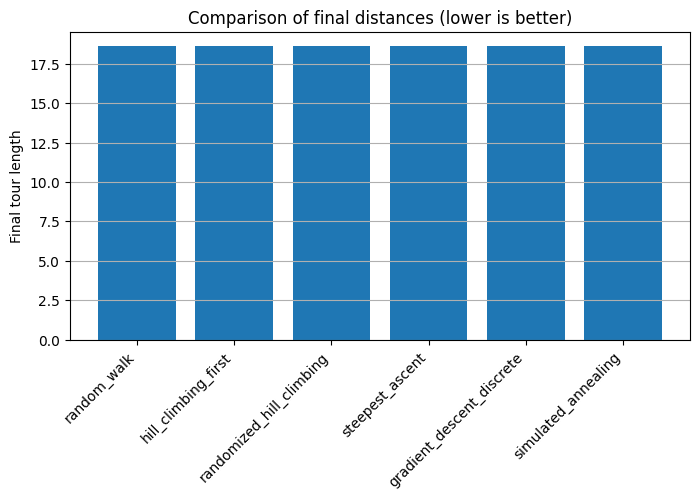

In [ ]:
rows = []
for name, info in RESULTS.items():
    rows.append({'algorithm':name, 'final_distance':info['length'], 'time_s':info['time']})

df = pd.DataFrame(rows).sort_values('final_distance')

# Bar plot for final distances
plt.figure(figsize=(8,4))
plt.bar(df['algorithm'], df['final_distance'])
plt.ylabel('Final tour length')
plt.xticks(rotation=45, ha='right')
plt.title('Comparison of final distances (lower is better)')
plt.grid(axis='y')
plt.show()

In [ ]:
df

,algorithm,final_distance,time_s
0,random_walk,18.586961,0.007212
1,hill_climbing_first,18.586961,0.000586
2,randomized_hill_climbing,18.586961,0.001948
3,steepest_ascent,18.586961,0.000732
4,gradient_descent_discrete,18.586961,0.000446
5,simulated_annealing,18.586961,0.018401




---



# CONSTRAINT SATISFACTION (CS)

This last 3 examples are constraint problems that can be solved using search or optimization algorithms (like hill climbing, simulated annealing, etc).

These serve as test cases for LS algortihms.

For these 3 problems, we will use "Gradient Ascent" and "Hill Climbing" as a test and comparison between their results

**1. 8 Queens**

Seeks to place 8 queens on a chessboard so that none of them attack each other. It's CS. Each solution represents positions of 8 queens, one per column. The objective is to minimize the number of conflicts (attacks) between queens.


In [ ]:
def count_conflicts_queens(cols):
# Return number of attacking pairs of queens for a configuration `cols`.
# cols: list or tuple of length N where cols[i] is column of queen in row i.

  n = len(cols)
  conflicts = 0
  for i in range(n):
    for j in range(i+1, n):
      if cols[i] == cols[j] or abs(cols[i] - cols[j]) == abs(i - j):
        conflicts += 1
  return conflicts


def is_solution_queens(cols):
# Return True if cols is a valid solution (no conflicts)."""
  return count_conflicts_queens(cols) == 0

*Hill Climbing Implementation*

In [ ]:
def hill_climb_queens(n=8, max_steps=20000, seed=0):

  random.seed(seed)
  cols = [random.randrange(n) for _ in range(n)]

  for step in range(max_steps):
    if count_conflicts_queens(cols) == 0:
      return cols

# choose a conflicted row
  conflicts = [0]*n

  for r in range(n):
    cnt = 0
    for r2 in range(n):
      if r==r2: continue
      if cols[r]==cols[r2] or abs(cols[r]-cols[r2])==abs(r-r2):
        cnt +=1
    conflicts[r]=cnt
  conflicted_rows = [r for r,c in enumerate(conflicts) if c>0]
  row = random.choice(conflicted_rows)

# move queen in this row to best column
  best_val = math.inf
  best_cols=[]

  for c in range(n):
    old = cols[row]
    cols[row]=c
    val = 0

    for r2 in range(n):
      if r2==row: continue
      if cols[row]==cols[r2] or abs(cols[row]-cols[r2])==abs(row-r2):
        val +=1
    cols[row]=old
    if val < best_val:
      best_val = val
      best_cols=[c]
    elif val==best_val:
      best_cols.append(c)
  cols[row] = random.choice(best_cols)
  return cols

*Gradient Ascent Implementation*

In [ ]:
def gradient_ascent_queens(n=8, max_steps=20000, seed=0):

  random.seed(seed)
  cols = [random.randrange(n) for _ in range(n)]

  for step in range(max_steps):
    current = -count_conflicts_queens(cols)
    best_val = current
    best_cols = list(cols)

    for r in range(n):
      for c in range(n):
        if cols[r]==c: continue
        cols[r]=c
        val = -count_conflicts_queens(cols)

        if val>best_val:
          best_val=val
          best_cols=list(cols)
      cols[r]=best_cols[r]
    cols=best_cols
    if -best_val==0:
      break
  return cols

**2. Map Coloring**

Assigns colors to regions of a map so that no adjacent regions share the same color. It's CS too, solvable by local search or optimization. Each state represents a coloring configuration. The objective is to minimize the number of color conflicts between neighboring regions.

In [ ]:
GRAPH = {
0: [1,2],
1: [0,2,3],
2: [0,1,3,4],
3: [1,2,4,5],
4: [2,3,5,6],
5: [3,4,6],
6: [4,5]
}


def count_conflicts_coloring(assign, graph=GRAPH):
#Count number of adjacent pairs with the same color.
#assign: dict node->color (colors are integers 0..k-1)

  conflicts = 0

  for u, neigh in graph.items():
    for v in neigh:
      if u < v and assign.get(u) == assign.get(v):
        conflicts += 1
  return conflicts


def is_valid_coloring(assign, graph=GRAPH):
  return count_conflicts_coloring(assign, graph) == 0

*Hill Climbing Implementation*

In [ ]:
def hill_climb_coloring(graph=GRAPH, k=3, max_steps=10000, seed=0):

    random.seed(seed)
    assign = {u: random.randrange(k) for u in graph.keys()}

    for step in range(max_steps):
        conflicts = count_conflicts_coloring(assign, graph)
        if conflicts==0:
            return assign

        conflicted = [u for u in graph.keys() if any(assign[u]==assign[v] for v in graph[u])]
        u = random.choice(conflicted)
        best_val = math.inf
        best_colors=[]

        for color in range(k):
            old = assign[u]
            assign[u]=color
            val = sum(1 for v in graph[u] if assign[u]==assign[v])
            assign[u]=old
            if val<best_val:
                best_val=val
                best_colors=[color]
            elif val==best_val:
                best_colors.append(color)

        assign[u]=random.choice(best_colors)

    return assign

*Gradient Ascent Implementation*

In [ ]:
def gradient_ascent_coloring(graph=GRAPH, k=3, max_steps=10000, seed=0):

    random.seed(seed)
    assign = {u: random.randrange(k) for u in graph.keys()}

    for step in range(max_steps):
        current = -count_conflicts_coloring(assign, graph)
        best_val = current
        best_assign = dict(assign)

        for u in graph.keys():
            for color in range(k):
                if assign[u]==color: continue
                assign[u]=color
                val = -count_conflicts_coloring(assign, graph)
                if val>best_val:
                    best_val = val
                    best_assign = dict(assign)
            assign[u]=best_assign[u]
        assign=best_assign

        if -best_val==0:
            break

    return assign

**9. Magic Triangle**

Consist of placing numbers on the side of a triangle so that the sum of the numbers on each side is the same. The algorithm will try different permutations of numbers and evaluates how close each configuration is to the constant.

In [ ]:

# 'perm' array with position numbers 0 to 5, work as a metric that will minimize
# the algorithms
def magic_cost(perm):
    sums = side_sums(perm)
    mean = sum(sums)/len(sums)
    return sum(abs(s - mean) for s in sums)

SIDES = [(0,1,2), (2,3,4), (4,5,0)]

def side_sums(arr):
#Return list of sums for the three sides given array-like `arr` of length 6."""
  return [sum(arr[i] for i in side) for side in SIDES]


def is_magic_triangle(arr):
  sums = side_sums(arr)
  return sums[0] == sums[1] == sums[2]


# Small brute-force example generator
def find_any_magic_triangle():
  nums = [1,2,3,4,5,6]
  for perm in itertools.permutations(nums):
    if is_magic_triangle(perm):
      return perm, side_sums(perm)
  return None, None

*Hill Climbing Implementation*

In [ ]:
def hill_climb_magic(max_iters=5000, seed=0):

    random.seed(seed)
    perm = list(random.sample(range(1,7),6))

    for it in range(max_iters):
        improved=False
        for i in range(6):
            for j in range(i+1,6):
                cand = perm.copy()
                cand[i], cand[j]=cand[j], cand[i]
                if magic_cost(cand)<magic_cost(perm):
                    perm=cand
                    improved=True
                    break
            if improved: break
        if not improved or magic_cost(perm)==0:

            break
    return perm

*Gradient Ascent Implementation*

In [ ]:
def gradient_ascent_magic(max_iters=5000, seed=0):

    random.seed(seed)
    perm = list(random.sample(range(1,7),6))

    for it in range(max_iters):
        current = -magic_cost(perm)
        best_val = current
        best_perm = list(perm)
        for i in range(6):
            for j in range(i+1,6):
                perm[i], perm[j] = perm[j], perm[i]
                val = -magic_cost(perm)
                if val>best_val:
                    best_val = val
                    best_perm = list(perm)
                perm[i], perm[j] = perm[j], perm[i]
        perm=best_perm
        if -best_val==0:
            break

    return perm

In [ ]:

seeds = [42]  # can extend for multiple runs

# Run each solver once (or multiple seeds) and collect metrics
results = []

# Eight Queens
for seed in seeds:
    t0 = time.time()
    hc_res = hill_climb_queens(8, seed=seed)
    t1 = time.time()
    ga_res = gradient_ascent_queens(8, seed=seed)
    t2 = time.time()
    results.append({
        'Problem': 'Eight Queens',
        'Algorithm': 'Hill Climbing',
        'Metric': count_conflicts_queens(hc_res),
        'Time_s': t1-t0
    })
    results.append({
        'Problem': 'Eight Queens',
        'Algorithm': 'Gradient Ascent',
        'Metric': count_conflicts_queens(ga_res),
        'Time_s': t2-t1
    })

# Map Coloring
for seed in seeds:
    t0 = time.time()
    hc_res = hill_climb_coloring(GRAPH, k=3, seed=seed)
    t1 = time.time()
    ga_res = gradient_ascent_coloring(GRAPH, k=3, seed=seed)
    t2 = time.time()
    results.append({
        'Problem': 'Map Coloring',
        'Algorithm': 'Hill Climbing',
        'Metric': count_conflicts_coloring(hc_res),
        'Time_s': t1-t0
    })
    results.append({
        'Problem': 'Map Coloring',
        'Algorithm': 'Gradient Ascent',
        'Metric': count_conflicts_coloring(ga_res),
        'Time_s': t2-t1
    })

# Magic Triangle
for seed in seeds:
    t0 = time.time()
    hc_res = hill_climb_magic(seed=seed)
    t1 = time.time()
    ga_res = gradient_ascent_magic(seed=seed)
    t2 = time.time()
    results.append({
        'Problem': 'Magic Triangle',
        'Algorithm': 'Hill Climbing',
        'Metric': magic_cost(hc_res),
        'Time_s': t1-t0
    })
    results.append({
        'Problem': 'Magic Triangle',
        'Algorithm': 'Gradient Ascent',
        'Metric': magic_cost(ga_res),
        'Time_s': t2-t1
    })

Summary = pd.DataFrame(results)
Summary


,Problem,Algorithm,Metric,Time_s
0,Eight Queens,Hill Climbing,7.0,0.097439
1,Eight Queens,Gradient Ascent,1.0,5.786824
2,Map Coloring,Hill Climbing,0.0,0.000230
3,Map Coloring,Gradient Ascent,0.0,0.000059
4,Magic Triangle,Hill Climbing,0.0,0.000097
5,Magic Triangle,Gradient Ascent,0.0,0.000064
